<a href="https://colab.research.google.com/github/RosanaAlves/Descargas-Atmosfericas/blob/main/Analise_Descritiva_v01_11-12-23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analises descritivas sobre descargas atmosféricas no estado de Minas Gerais


Este estudo conta com dados de descargas atmosféricas coletadas durante o ano de 2022 no Estado de Minas Gerais.

De acordo com o INPE (Instituto Nacional de Pesquisas Espaciais), descargas atmosféricas são descargas elétricas de grande extensão (alguns quilômetros) e de grande intensidade (picos de intensidade de corrente acima de um quiloàmpere), que ocorrem devido ao acúmulo de cargas elétricas em regiões localizadas da atmosfera, em geral dentro de tempestades.
Elas podem ocorrer tanto no interior de uma nuvem, como entre nuvens ou entre uma nuvem e a terra.

É importante estudar esse tipo de evento, a fim de poder evitá-lo ou ainda, reduzir seus efeitos. Através de análises, é possível verificar a existência de algum tipo de padrão em sua ocorrência, principalmente,  no caso de descargas entre nuvem e terra.
Essas descargas podem ocasionar muitos prejuízos em plantações, criações de animais e aparelhos eletrodomésticos.

 Sendo assim, o objetivo deste estudo é fazer uma análise descritiva dos dados, utilizando linguagem Python. Os resultados são apenas para apontamentos e suposições que poderão ser aprofundadas em um estudo posterior.


In [ ]:
# pip install folium
# pip install geopandas matplotlib

## Análise descritiva

In [37]:
# Bibliotecas

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import folium
import geopy
import geopandas as gpd
from shapely.geometry import Point


In [39]:
# Carregando o arquivo csv

dados_df = pd.read_csv("https://raw.githubusercontent.com/RosanaAlves/Descargas-Atmosfericas/main/dataset_2022.csv?token=GHSAT0AAAAAACLXDSMR7RPQLMTGHE2YNHEAZL7EPIA")
dados_df;

In [40]:
# Alterando a primeira letra do nome de cada coluna.

dados_df.columns = dados_df.columns.str.strip().str.capitalize()
dados_df;

In [41]:
df = dados_df
df['Data'];

In [42]:
# Alterando o formato da coluna Data para data e hora.

df['Data'] = pd.to_datetime(df['Data'])
df['Data'];

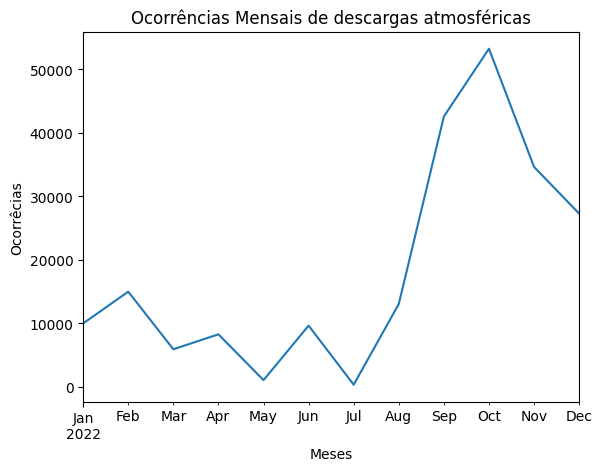

In [49]:
# Plotando a contagem de descargas por mês

df.set_index('Data').resample('M').size().plot() # Agrupando por mês
plt.title('Ocorrências Mensais de descargas atmosféricas')
plt.xlabel('Meses')
plt.ylabel('Ocorrêcias')
plt.show()
#

Segundo INMET (Instituto Nacional de Meteorologia), a estação chuvosa em Minas Gerais, assim como, em toda a Região Sudeste, ocorre entre os meses de outubro a março, porém as primeiras pancadas de chuva, normalmente ocorrem na segunda quinzena de setembro, evidenciando o declínio da estação seca.


Olhando para o gráfico, as maiores ocorrências de descargas atmosféricas ocorreram entre agosto e dezembro de 2022, tendo seu maior pico em outubro. Exatamente como era esperado, já que é período de chuvas. Contudo, esse pico pode evidenciar que a transição para a estação chuvosa influencia a incidência de raios, pois, após esse pico houve uma queda.


In [60]:
# Frequencia de descargas por tipo de descarga

df['Tipo'].value_counts()

1     142180
0      78407
40       114
Name: Tipo, dtype: int64

O tipo (0) indica descarga nuvem-solo e o tipo (1) intranuvem, o tipo (40) não foi declarado, por isso, pode ser considerado um valor inconsistente.
Os valores inconsistentes não podem ser apagados sem antes serem analisados, sendo assim, é necessário uma investigação mais profunda.

In [51]:
# Selecionando apenas o periodo de maior incidencia de descargas

df_me = df[(df['Data'] >= '2022-08-01') & (df['Data'] <= '2022-12-31')] # me- mudanca de estacao
df_me.shape
df_me['Tipo'].value_counts()


1     116729
0      53829
40       114
Name: Tipo, dtype: int64

Todas as ocorrências do valor (40), foram durante a estação chuvosa.


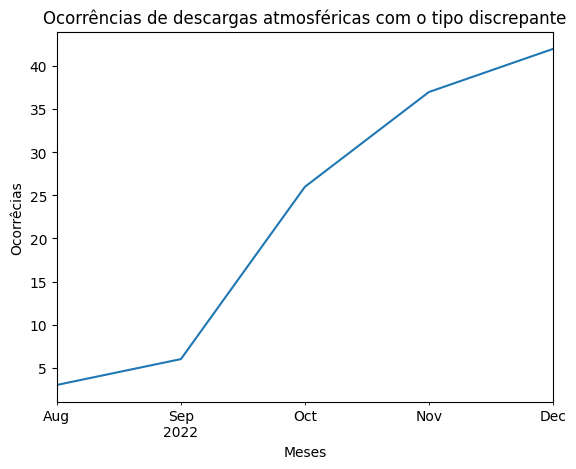

In [52]:
# filtrando valor inconsistente

df_filtrado = df[df['Tipo'] == 40]

df_filtrado.set_index('Data').resample('M').size().plot() # Agrupando por mês
plt.title('Ocorrências de descargas atmosféricas com o tipo discrepante')
plt.xlabel('Meses')
plt.ylabel('Ocorrêcias')
plt.show()


As ocorrências tiveram um comportamento crescente.


In [55]:
# Create a Geocoder object
geocoder = geopy.Nominatim(user_agent="my_user_agent")

# Get the location names for each latitude and longitude
for lat, lng in zip(df_filtrado['Latitude'], df_filtrado['Longitude']):
    location = geocoder.reverse((lat, lng))


df_filtrado['Nome'] = location.address

<ipython-input-55-52d3c3ccc1cb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Nome'] = location.address


In [56]:
df_filtrado['Nome'].unique;


In [81]:
# Coordenadas

latitude_ = -19.742283
longitude_ = -46.301591

# Criar um mapa em Minas Gerais
mapa_mg = folium.Map(location=[latitude_, longitude_], zoom_start=12)

# Adicionar marcadores para cada cidade no DataFrame
for index, row in df_filtrado.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Nome'],
        icon=folium.Icon(color='red')
    ).add_to(mapa_mg)

# Exibir o mapa
mapa_mg



A Região Geográfica Imediata de Formiga é uma das 70 regiões geográficas imediatas do Estado de Minas Gerais, uma das seis regiões geográficas imediatas que compõem a Região Geográfica Intermediária de Divinópolis e uma das 509 regiões geográficas imediatas do Brasil, criadas pelo IBGE em 2017.



## Analisando apenas as descargas nuvem-solo
Para poupar recurso computacional,  vou focar apenas no evento tipo 0, que  são as descargas nuvem-solo.

In [58]:
df_me_ns = df_me[df_me['Tipo'] == 0] # me- mudanca de estacao e ns-nuvem-solo
df_me_ns;


In [59]:
'''# Create a Geocoder object
geocoder = geopy.Nominatim(user_agent="my_user_agent")

# Get the location names for each latitude and longitude
for lat, lng in zip(df_me_ns['Latitude'], df_me_ns['Longitude']):
    location = geocoder.reverse((lat, lng))


df_me_ns['Nome'] = location.address'''

'# Create a Geocoder object\ngeocoder = geopy.Nominatim(user_agent="my_user_agent")\n\n# Get the location names for each latitude and longitude\nfor lat, lng in zip(df_me_ns[\'Latitude\'], df_me_ns[\'Longitude\']):\n    location = geocoder.reverse((lat, lng))\n\n\ndf_me_ns[\'Nome\'] = location.address'

In [79]:
  # Construindo os mapas

  import matplotlib.pyplot as plt

# Coordenadas do centro de Minas Gerais
latitude_p = float(df['Latitude'].values[0])
longitude_p = float(df['Longitude'].values[0])

# Coordenadas das cidades fictícias
 # = {'Cidade A': (-18.8918, -48.2625), 'Cidade B': (-19.9167, -43.9333), 'Cidade C': (-21.1700, -43.8100)}

# Criar um gráfico de dispersão
plt.scatter([longitude_p] + [coord[1] for coord in df['Latitude'].values().tolist()],
            [latitude_p] + [coord[0] for coord in df['Longitude'].values().tolist()], c='red')

# Adicionar rótulos para as cidades
'''for cidade, coord in cidades.items():
    plt.text(coord[1], coord[0], cidade)
'''
# Adicionar rótulo para o centro de Minas Gerais
plt.text(longitude_centro, latitude_centro, 'Minas Gerais', fontsize=12, ha='right')

# Exibir o gráfico
plt.show()



IndentationError: ignored

In [71]:
# Verificando quel é o tipo de variavel resutante

type(df['Latitude'].values[0])


numpy.float64

In [78]:
import plotly.express as px

latitude_p = float(df['Latitude'].values[0])
longitude_p = float(df['Longitude'].values[0])

# Criar um mapa usando Plotly Express
figura = px.scatter_geo(df_filtrado, lat='Latitude', lon='Longitude',  size_max=30)

# Atualizar layout para centrar no Brasil
#figura.update_layout(center={'lat': -14.2350, 'lon': -51.9253})
figura.update_geos(center=dict(lon=longitude_p, lat=latitude_p), projection_scale=7)

# Exibir o mapa
figura.show()


In [ ]:
folium.Map(location = [-20.326783,-45.989391], zoom_start = 9);


In [ ]:
# nome = df['nome']
mapa = folium.Map(location=[-20.326783,-45.989391],
                  zoom_start=12.25)
mapa